Either install learnMSA via pip or clone github.com/Ung0d/MSA-HMM as a sibling directory of MSA-HMM-Analysis and change the relative search path in the cell below. The notebook assumes that you have downloaded the benchmark data, i.e. "data" contains the directories "homfam", "balifam*" and (optionally) "large". All cells except the ones that produce the figure for the ultra large experiments also work without the large data.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, '../MSA-HMM')
from learnMSA import msa_hmm

## Evaluation 

Datasets:

- HomFam
- Balifam (100, (1000), 10000 homologs) + fragmentary version
- Ultra large (0.5-3 million sequences)

Comparison tools:

- clustalo
- t_coffee regressive
- MAGUS
- UPP
- mafft sparsecore / mafft parttree


Alignments were constructed on refs + homologs and scores computed for the induced alignment only on the reference sequences. SP and TC score were computed using t_coffee's -aln_compare option. The scores are computed with respect to all residues indepent of structural relevance.

In [2]:
datasets = ["homfam", "balifam100", "balifam10000", "balifrag", "large"]
msa_methods = ["msa_hmm", "clustalo", "mafft", "upp", "reg", "MAGUS"]
msa_method_names = ["learnMSA", "Clustal Omega", "MAFFT", "UPP", "regressive T-Coffee", "MAGUS"] #used in figures
msa_method_colors = ["mediumturquoise", "sandybrown", "yellowgreen", "khaki", "plum", "indianred"]

In [3]:
def load_or_generate_stats(dir_path, df_filepath, ext, gaps):
    if not os.path.exists(df_filepath):
        with open(df_filepath, "w") as file:
            file.write(",".join(["family", "num_seqs", "min_l", "max_l", "avg_l"]) + "\n")
            for filename in os.listdir(dir_path):
                if not filename.endswith(ext):
                    continue
                f = filename[:-len(ext)]
                fasta_file = msa_hmm.fasta.Fasta(dir_path+"/"+filename)
                min_l = np.amin(fasta_file.seq_lens)
                max_l = np.amax(fasta_file.seq_lens)
                avg_l = np.mean(fasta_file.seq_lens)
                file.write(",".join([f, str(fasta_file.num_seq), str(min_l), str(max_l), str(avg_l)])+"\n")
    df = pd.read_csv(df_filepath)  
    return df
        
def summarize(df):
    print(df.shape[0], " datasets.")
    print("A total of", np.sum(df.num_seqs), "sequences.")
    argmin_num = np.argmin(df.num_seqs)
    argmax_num = np.argmax(df.num_seqs)
    min_num, min_num_id = df.num_seqs.iloc[argmin_num], df.family.iloc[argmin_num]
    max_num, max_num_id = df.num_seqs.iloc[argmax_num], df.family.iloc[argmax_num]
    avg_num = np.mean(df.num_seqs)
    argmin_len = np.argmin(df.min_l)
    argmax_len = np.argmax(df.max_l)
    min_len, min_len_id = df.min_l.iloc[argmin_len], df.family.iloc[argmin_len]
    max_len, max_len_id = df.max_l.iloc[argmax_len], df.family.iloc[argmax_len]
    avg_len = np.mean(df.avg_l)
    print("Number of sequences:", min_num, "("+min_num_id+") -",max_num, "("+max_num_id+")", " average=", avg_num)
    print("Sequence lengths:", min_len,"("+min_len_id+") -", max_len, "("+max_len_id+")", " average=", avg_len)
    
def get_tuple(df, name):
    return tuple(df.loc[df.family == name].iloc[0][1:])

stat_dfs = {}
for d in datasets:
    stat_dfs[d] = {}
    for name in ["train", "refs"]:
        ext = ".fasta" if name=="train" else ".ref"
        stat_dfs[d][name] = load_or_generate_stats("data/"+d+"/"+name, "data/"+d+"/"+name+"_stats.csv", ext, name=="refs")
    
for d in datasets:
    for name in ["train", "refs"]:
        print("-"*50+"\n", d, name, "\n", "-"*50)
        summarize(stat_dfs[d][name])

--------------------------------------------------
 homfam train 
 --------------------------------------------------
94  datasets.
A total of 752643 sequences.
Number of sequences: 93 (seatoxin) - 93681 (rvp)  average= 8006.840425531915
Sequence lengths: 12 (hom) - 854 (rhv)  average= 148.42410003950866
--------------------------------------------------
 homfam refs 
 --------------------------------------------------
94  datasets.
A total of 780 sequences.
Number of sequences: 5 (DMRL_synthase) - 41 (glob)  average= 8.297872340425531
Sequence lengths: 14 (bowman) - 854 (rhv)  average= 214.83972479557437
--------------------------------------------------
 balifam100 train 
 --------------------------------------------------
59  datasets.
A total of 7510 sequences.
Number of sequences: 104 (PF07654.100) - 242 (PF00202.100)  average= 127.28813559322033
Sequence lengths: 20 (PF00037.100) - 764 (PF00343.100)  average= 161.30824012312402
--------------------------------------------------
 

In [4]:
stat_dfs["large"]["train"]

,family,num_seqs,min_l,max_l,avg_l
0,PF13855.9,766271,26,73,56.997023
1,PF00400.35,1594257,12,101,35.104631
2,PF00005.30,3489586,18,683,145.827443
3,PF07679.19,579519,25,149,83.446760
4,PF07690.19,1861106,37,577,284.156681
5,PF00041.24,666310,27,139,80.666056
6,PF00069.28,1154714,24,511,227.253479
7,PF00096.29,1783511,12,34,22.980977
8,PF12796.10,945198,27,153,77.649023
9,PF00072.27,1767045,28,156,109.713852


### Scatterplots (only homfam)

In [5]:
def load_results(results_file, c_left=0, c_right=1e6):
    dataset = results_file.split(".")[-2]
    results = {}
    if not os.path.exists(results_file):
        return {}
    with open(results_file, "r") as file:
        for line in file.readlines():
            line = line.rstrip().split()
            if len(line) == 6:
                results[line[0]] = [float(line[i+1]) for i in range(4)] + [float(line[5].split("m")[0])]
    def in_range(frac):
        return frac > c_left and frac <= c_right
    return { f : data for f, data in results.items() 
            if in_range(get_tuple(stat_dfs[dataset]["refs"], f)[3] / get_tuple(stat_dfs[dataset]["train"], f)[3]) }

In [6]:
for m in msa_methods:
    print(m)
    for d in datasets:
        if m == "clustalo" and d == "large":
            continue
        results = load_results("results/"+m+"/"+m+"."+d+".out")
        print(np.mean(list(results.values()), axis=0), d)

msa_hmm
[79.52978723 80.44574468 56.49042553 61.68085106 14.23404255] homfam
[75.1440678  77.27966102 39.66610169 43.47118644  4.77966102] balifam100
[75.375      78.06666667 40.         44.51666667 25.75      ] balifam10000
[68.64722222 72.10833333 36.37222222 37.25       17.86111111] balifrag
[ 75.8   75.08  18.55  23.69 362.9 ] large
clustalo
[80.50531915 87.14893617 58.13617021 61.80319149  1.5       ] homfam
[78.87627119 81.93898305 41.52881356 45.37288136  0.        ] balifam100
[69.76944444 82.19444444 32.57222222 35.70277778  2.02777778] balifam10000
[62.66944444 78.625      28.025      28.          1.47222222] balifrag
mafft
[82.66808511 86.15212766 59.36489362 64.67765957 11.39361702] homfam
[82.9220339  84.60847458 47.92542373 52.6         0.08474576] balifam100
[76.59444444 82.28611111 37.99722222 41.30277778 12.97222222] balifam10000
[73.88333333 79.61388889 37.89722222 39.275      16.88888889] balifrag
[ 54.4375  67.3625   5.325    6.7125 563.375 ] large
upp
[76.45319149 

In [7]:
#find the large families, where the average score over all methods is above 50%
score_type = 0 #0 for SP, 2 for TC
large_results = [load_results("results/"+m+"/"+m+".large.out") for m in msa_methods]
avg_over_methods = []
for k in large_results[0].keys():
    s = 0
    for r in large_results:
        if k in r:
            s += r[k][score_type]
    s /= len(large_results)
    avg_over_methods.append((s, k))
    
print(avg_over_methods)
print([k for s,k in avg_over_methods if s >= 50])

[(24.733333333333334, 'PF00005.30'), (47.833333333333336, 'PF00069.28'), (71.33333333333334, 'PF00096.29'), (0.483333333333334, 'PF00400.35'), (35.41666666666667, 'PF12796.10'), (51.133333333333326, 'PF00041.24'), (55.75, 'PF00072.27'), (63.18333333333333, 'PF07679.19'), (17.95, 'PF07690.19'), (68.36666666666666, 'PF13855.9')]
['PF00096.29', 'PF00041.24', 'PF00072.27', 'PF07679.19', 'PF13855.9']


In [8]:
#map protein families to structure categories (aLpha, beta, multidomain, ...)
categories = {} #only for homfam
seq_ids = {}
with open("data/homfam.categories.txt", "r") as cat_file:
    for line in cat_file.readlines():
        d = line.split(" ")
        categories[d[0]] = d[1]
        seq_ids[d[0]] = float(d[2])
cat_all = list(set(categories.values()))

In [9]:
#only for homfam
def score_diff_plot(results, ref_results, results_name, ref_name, legend, x_axis="overlength"):
    sps = []
    score_diffs = []
    overlength = []
    lengths = []
    num_seqs = []
    family_names = []
    cat = []
    seq_id = []
    results_data = np.array(list(results.values()))
    ref_data = np.array(list(ref_results.values()))
    for family_name, scores in results.items():
        ref_scores = ref_results[family_name]
        family_names.append(family_name)
        cat.append(categories[family_name])
        seq_id.append(seq_ids[family_name])
        sps.append(scores[0])
        score_diffs.append(scores[0] - ref_scores[0]) 
        #relative length diff
        mean_lens = get_tuple(stat_dfs["homfam"]["train"], family_name)[3]
        lengths.append(mean_lens)
        mean_ref_lens = get_tuple(stat_dfs["homfam"]["refs"], family_name)[3]
        overlength.append(mean_ref_lens / mean_lens)
        num_seqs.append(get_tuple(stat_dfs["homfam"]["train"], family_name)[0])
    if x_axis == "overlength":
        x = np.array(overlength)
        x_label = "relative reference length"
    elif x_axis == "number of sequences":
        x = np.array(num_seqs)
        x_label = x_axis
    elif x_axis == "length":
        x = np.array(lengths)
        x_label = "avg. sequence length"    
    elif x_axis == "seq id":
        x = np.array(seq_id)
        x_label = "sequence identity"
    else:
        print("x-axis value type unknown")
        return
    score_diffs = np.array(score_diffs)
    sps = np.array(sps)
    cat = np.array(cat)
    markers = ["o", "s", "D", "*", "P", "X", "1", "v"]
    fig, (ax1) = plt.subplots(1, 1)
    plt.title(("SP score comparison of "+results_name+" and "+ref_name))#+" \n"+
              #results_name+" avg. SP= %.2f "+ref_name+" avg. SP= %.2f") % (np.mean(results_data[:,0]), np.mean(ref_data[:,0])))
    fig.set_size_inches(8, 10)
    handles = []
    for c,m in zip(cat_all, markers):
        h, = ax1.plot(x[cat==c], score_diffs[cat==c], m,  markersize=10)
        handles.append(h)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("score difference")
    keys = [c.replace("_", " ")+" (SP="+"%.2f" % np.mean(sps[cat==c])+", n="+str(int(np.sum(cat==c)))+")" for c in cat_all]
    if legend:
        ax1.legend(handles, keys, loc=(0.52, 0.3))
    ax1.axhline(y=0, color='r', linestyle='-')
    scale = ax1.get_xlim()[1] - ax1.get_xlim()[0]
    for i,family in enumerate(family_names):
        ax1.annotate(family, (x[i]+0.01*scale, score_diffs[i]), zorder=-1).set_alpha(.6)

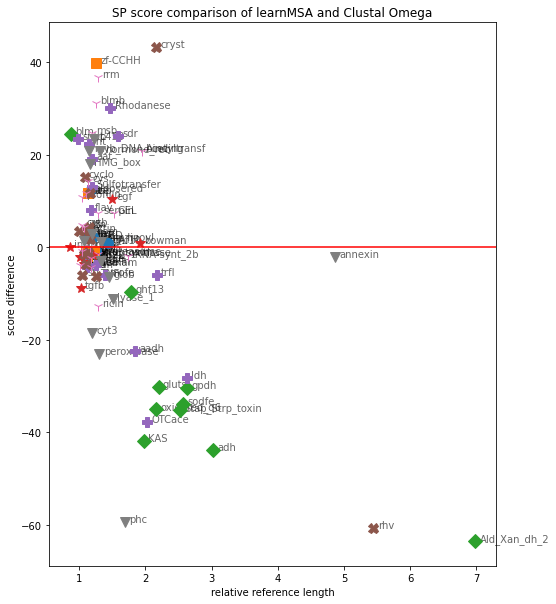

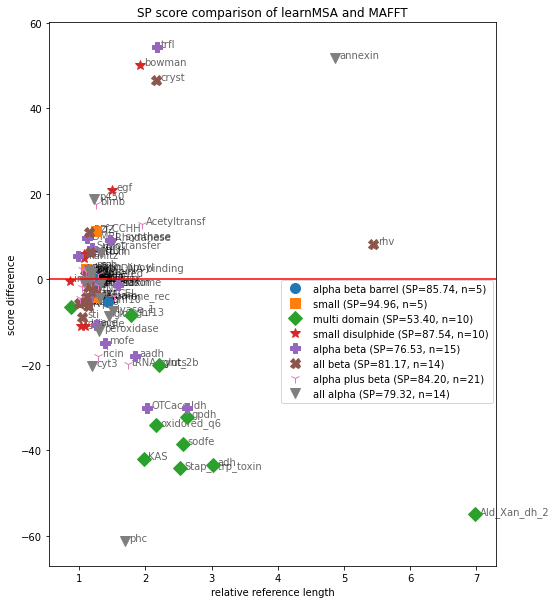

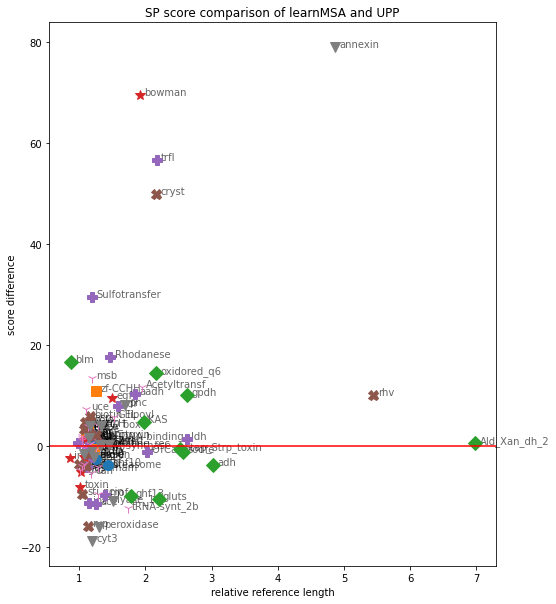

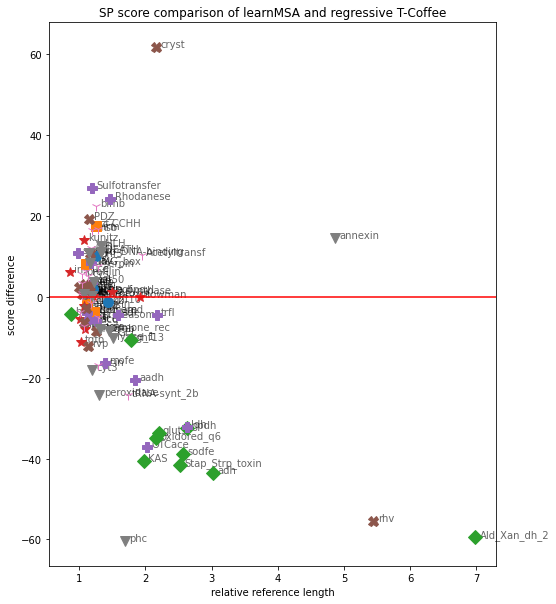

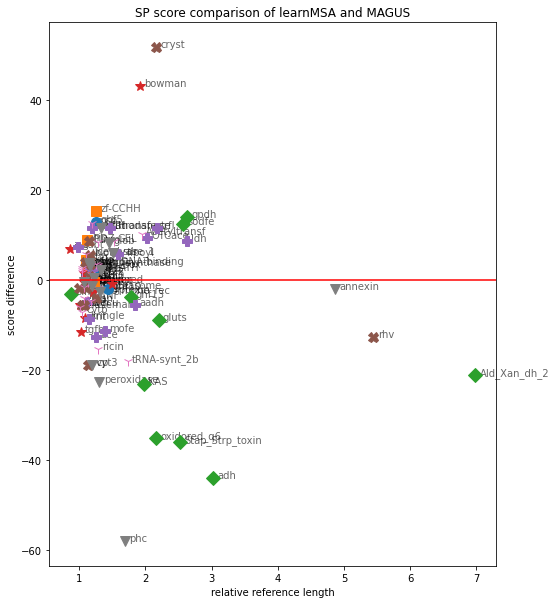

In [10]:
for m, name in zip(msa_methods[1:], msa_method_names[1:]):
    legend = m == "mafft"
    score_diff_plot(load_results("results/msa_hmm/msa_hmm.homfam.out"), 
                    load_results("results/"+m+"/"+m+".homfam.out"), 
                    "learnMSA", name, legend, "overlength")
    plt.savefig("fig/hmm_"+name+"_overlength.pdf", bbox_inches='tight')

### Boxplots

In [11]:
#hmm_scores : list of score-dicts for each group
#hmm_scores : list of lists of score-dicts, outer dim = methods, inner dim = groups
def make_boxplots(hmm_scores, 
                  ref_scores,
                  group_names,
                  names, 
                  colors, #1 + num_refs many colors expected
                  plot_title,
                  score="sp", #sp, modeler, pairs, tc, column 
                  tiling = 6,
                  ylim=(-10, 110),
                 ylabel=None): 
    def get_scores(x):
        if score == "sp":
            return x[:,0]
        if score == "modeler":
            return x[:,1]
        if score == "pairs":
            return (x[:,0] + x[:,1]) / 2
        if score == "tc":
            return x[:,2]
        if score == "column":
            return x[:,3]
    num_groups = len(hmm_scores)
    group_sizes = [len(list(scores.values())) for scores in hmm_scores]
    for i,ref in enumerate(ref_scores):
        assert len(ref) == num_groups, "Number of groups should be the same for HMM and all refs." 
        def comp_lists(l1,l2): #assumes that l1 and l2 have equal length
            return len([i for i,j in zip(l1,l2) if i==j]) == len(l1)
        assert comp_lists([len(list(scores.values())) for scores in ref], group_sizes), f"Group sizes should be equal for HMM and ref {i}: {[len(list(scores.values())) for scores in ref]} != {group_sizes}"  
    #convert score-dicts to arrays, keep list structure
    hmm_scores_arr = []
    ref_scores_arr = []
    for scores in hmm_scores:
        hmm_scores_arr.append(get_scores(np.array(list(scores.values()))))
    for ref in ref_scores:
        ref_scores_arr.append([])
        for scores in ref:
            ref_scores_arr[-1].append(get_scores(np.array(list(scores.values()))))
    #make plots
    plt.rcParams["figure.figsize"] = (7, 5)
    plt.rcParams["font.size"] = 12
    fig = plt.figure()
    fig.patch.set_alpha(1)  
    
    meanprops = dict(marker='D', markeredgecolor='black',
                  markerfacecolor='firebrick')
    bp_hmm = plt.boxplot(hmm_scores_arr, 
                         positions=np.array(range(num_groups))*tiling-1.6, 
                         widths=0.6, 
                         patch_artist=True, boxprops=dict(facecolor=colors[0]), 
                         showmeans=True, meanprops=meanprops)
    bp_ref = [plt.boxplot(d, 
                         positions=np.array(range(len(d)))*tiling-0.8+0.8*i, 
                         widths=0.6, 
                         patch_artist=True, boxprops=dict(facecolor=colors[i+1]), 
                         showmeans=True, meanprops=meanprops)
                  for i,d in enumerate(ref_scores_arr)]
    plt.setp(bp_hmm["medians"], color="black")
    for bp in bp_ref:
        plt.setp(bp["medians"], color="black")

    plt.title(plot_title)
    plt.legend([bp_hmm["boxes"][0]]+[bp["boxes"][0] for bp in bp_ref], names, 
               loc='lower right',
               ncol=3)

    x_pos = np.array(range(0, len(group_names) * tiling, tiling))
    plt.xticks(x_pos, group_names, size="large")
    if ylabel is None:
        plt.ylabel(score.upper() + " score", size="large")
    else:
        plt.ylabel(ylabel)
    if score=="tc":
        cur_ylim = plt.ylim()
        plt.ylim(cur_ylim[0]-12, cur_ylim[1])

    for i,n in enumerate(group_sizes):
        if group_names[0] == "":
            c = 6
        else:
            c = 16
        plt.text(x_pos[i], ylim[0]-c, "n="+str(n), ha="center")
    if num_groups == 1:
        plt.xticks([])
    plt.ylim(ylim)

    plt.tight_layout()

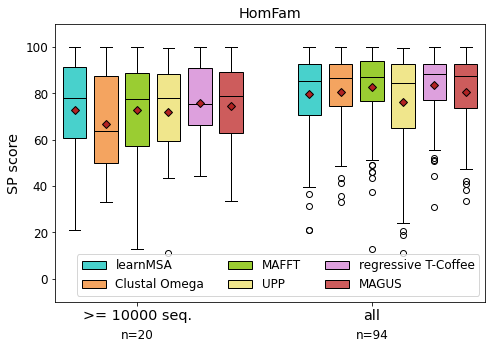

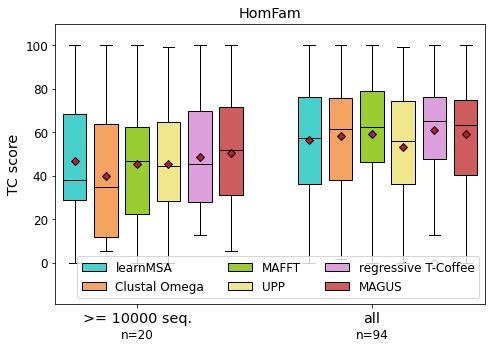

In [12]:
c = 1e6
num_split = int(1e4)

def split_by_num_seqs(results, dataset, num=num_split):
    lower, larger = {}, {}
    for family, scores in results.items():
        if get_tuple(stat_dfs[dataset]["train"], family)[0] < num:
            lower[family] = scores
        else:
            larger[family] = scores
    return [larger, results]

def plot_by_num_seqs(score, ylim=(-10,110)):
    make_boxplots(split_by_num_seqs(load_results("results/msa_hmm/msa_hmm.homfam.out", c_right=c), "homfam"), 
                    [split_by_num_seqs(load_results("results/"+m+"/"+m+".homfam.out", c_right=c), "homfam") for m in msa_methods[1:]],
                  group_names=[">= "+str(num_split)+" seq.", "all"],#["all", "< "+str(num_split)+" seq.", ">= "+str(num_split)+" seq."],
                  names=msa_method_names,
                  colors=msa_method_colors,
                  plot_title= "HomFam",
                  score=score,
                 ylim=ylim)
plot_by_num_seqs("sp")   
plt.savefig("fig/boxplots_sp_homfam.pdf", bbox_inches='tight') 
plt.savefig("fig/boxplots_sp_homfam.png") 
#plot_by_num_seqs("pairs")  
#plt.savefig("img/boxplots_pairs.pdf", bbox_inches='tight') 
plot_by_num_seqs("tc", ylim=(-19,110))   
plt.savefig("fig/boxplots_tc_homfam.pdf", bbox_inches='tight') 
#plot_by_num_seqs("column")   
#plt.savefig("img/boxplots_column.pdf", bbox_inches='tight')   

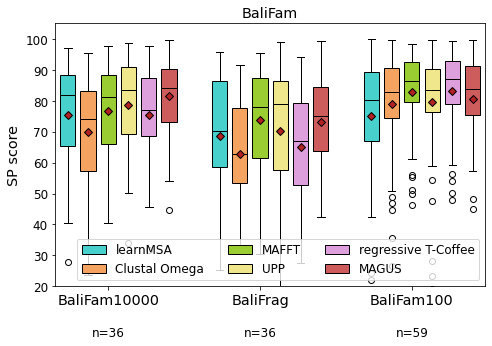

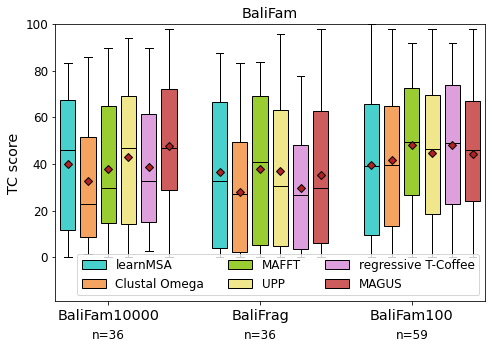

In [13]:
names=["balifam10000", "balifrag", "balifam100"]

def load_balifam(path):
    results = [load_results(path+"."+n+".out") for n in names]
    return results

def plot_balifam(score, ylim=(-10,110)):
    make_boxplots(load_balifam("results/msa_hmm/msa_hmm"), 
                    [load_balifam("results/"+m+"/"+m) for m in msa_methods[1:]],
                  group_names=["BaliFam10000", "BaliFrag", "BaliFam100"],
                  names=msa_method_names,
                  colors=msa_method_colors,
                  plot_title="BaliFam",
                  score=score,
                 ylim=ylim)
plot_balifam("sp", ylim=(20,105))   
plt.savefig("fig/boxplots_sp_balifam.pdf", bbox_inches='tight') 
#plot_balifam("pairs")
plot_balifam("tc", ylim=(-19,100))   
plt.savefig("fig/boxplots_tc_balifam.pdf", bbox_inches='tight') 
#plot_balifam("column")

## MSA expansion ratio

Only works with completed MSAs, which are not included in the git repo because of their size.

In [19]:
for m in msa_methods:
    if m == "clustalo":
        continue
    ref_msa_dir = "data/large/refs/"
    results_msa_dir = "results/"+m+"/alignments/"
    print(m)
    for filename in os.listdir(ref_msa_dir):
        if not filename.endswith(".ref"):
            continue
        f = filename[:-len(ext)] 
        path = results_msa_dir+f+".projection.fasta"
        if os.path.exists(path) and os.path.getsize(path) > 100: 
            ref_fasta = msa_hmm.fasta.Fasta(ref_msa_dir+filename, aligned=True)
            fasta = msa_hmm.fasta.Fasta(path)
            print(f, fasta.alignment_len / ref_fasta.alignment_len)

msa_hmm
PF00041.24 1.3418803418803418
PF12796.10 0.8544061302681992
PF00400.35 1.2923076923076924
PF00069.28 1.3675417661097853
PF07679.19 1.1061946902654867
PF07690.19 1.8184110970996217
PF00096.29 1.1612903225806452
PF00005.30 1.8941605839416058
PF00072.27 1.103448275862069
PF13855.9 1.0454545454545454
mafft
PF00041.24 7.829059829059829
PF12796.10 6.363984674329502
PF00400.35 7.707692307692308
PF00069.28 3.520286396181384
PF07679.19 3.3628318584070795
PF00096.29 2.7419354838709675
PF00072.27 3.689655172413793
PF13855.9 3.0454545454545454
upp
PF00041.24 2.1794871794871793
PF12796.10 3.1839080459770117
PF00400.35 2.6153846153846154
PF00069.28 1.6014319809069213
PF07679.19 1.4336283185840708
PF07690.19 2.4842370744010087
PF00096.29 2.225806451612903
PF00005.30 1.989051094890511
PF00072.27 1.3241379310344827
PF13855.9 1.7121212121212122
reg
PF00041.24 15.162393162393162
PF00400.35 51.284615384615385
PF07679.19 8.548672566371682
PF00096.29 6.548387096774194
PF13855.9 7.212121212121212
MAG